## 1. Descripción del corpus

Librerias

In [ ]:
import os
import re
import nltk
import ftfy
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from collections import Counter, defaultdict
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords


In [ ]:
#nltk.download("stopwords")

: 

Número de documentos, tokens y vocabulario.

In [2]:
# Configuracion
csv_path = "../data/raw/MeIA_2025_train.csv"
text_col = "Review"
classes = ["Polarity", "Town", "Region", "Type"]

# Cargamos el dataset y elegimos codificacion
df = pd.read_csv(csv_path, encoding='utf-8')

# Limpiamos un poco
df = df.dropna(subset=[text_col])                 # Elimina valores NaN
df = df[df[text_col].str.strip().ne("")]          # Elimina strings vacios
df.reset_index(drop=True, inplace=True)

# Imprimimos resultados
print("Columnas disponibles:", df.columns.tolist())
print("Número de documentos:", len(df))

# Visualizamos el df
df.head()

Columnas disponibles: ['Review', 'Polarity', 'Town', 'Region', 'Type']
Número de documentos: 5000


,Review,Polarity,Town,Region,Type
0,Un Restaurante te invita por su ambiente tan a...,2.0,Tlaquepaque,Jalisco,Restaurant
1,Pagamos 25 pesos por la entrada y no es gran c...,3.0,Bacalar,QuintanaRoo,Attractive
2,Mi esposa y yo nos alojamos en el Dreams por 4...,3.0,Tulum,QuintanaRoo,Hotel
3,"La única decepción puede no ser José Cuervo, p...",2.0,Tequila,Jalisco,Attractive
4,Cuando leí los comentarios sobre cómo son las ...,1.0,Isla_Mujeres,QuintanaRoo,Hotel


In [ ]:
# Clases por variable
for col in ["Polarity", "Town", "Region", "Type"]:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].unique()[:41])   # muestra hasta 40 valores únicos
        print("Total únicos:", df[col].nunique(dropna=False))



Polarity:
[2. 3. 1. 4. 5.]
Total únicos: 5

Town:
['Tlaquepaque' 'Bacalar' 'Tulum' 'Tequila' 'Isla_Mujeres' 'Atlixco'
 'San_Cristobal_de_las_Casas' 'Tepoztlan' 'Taxco' 'Sayulita' 'Teotihuacan'
 'Ajijic' 'Valle_de_Bravo' 'TodosSantos' 'Huasca_de_Ocampo' 'Zacatlan'
 'Valladolid' 'Patzcuaro' 'Cuetzalan' 'Tepotzotlan' 'Cholula' 'Palenque'
 'Loreto' 'Malinalco' 'Tequisquiapan' 'Orizaba' 'Chiapa_de_Corzo' 'Parras'
 'Bernal' 'Mazunte' 'Ixtapan_de_la_Sal' 'Cuatro_Cienegas' 'Xilitla'
 'Creel' 'Izamal' 'Tapalpa' 'Metepec' 'Coatepec' 'Dolores_Hidalgo'
 'Real_de_Catorce']
Total únicos: 40

Region:
['Jalisco' 'QuintanaRoo' 'Puebla' 'Chiapas' 'Morelos' 'Guerrero' 'Nayarit'
 'Estado_de_Mexico' 'Baja_CaliforniaSur' 'Hidalgo' 'Yucatan' 'Michoacan'
 'Queretaro' 'Veracruz' 'Coahuila' 'Oaxaca' 'San_Luis_Potosi' 'Chihuahua'
 'Guanajuato']
Total únicos: 19

Type:
['Restaurant' 'Attractive' 'Hotel']
Total únicos: 3


In [4]:
# Contamos los mojibakes "Ã"
count_before = df[text_col].astype(str).str.count("Ã").sum()
print(f"Número de 'Ã' antes de ftfy: {count_before}")

# Aplicamos ftfy
df["Review_clean"] = df[text_col].apply(ftfy.fix_text)

# Contamos de nuevo después
count_after = df["Review_clean"].astype(str).str.count("Ã").sum()
print(f"Número de 'Ã' después de ftfy: {count_after}")

# Removemos casos tipo "...Mas" al final del texto por scrapeo
def remove_scrape_artifacts(text: str):
    if not isinstance(text, str):
        return text
    return re.sub(r"Más[\s\W]*$", "", text)
# Aplicamos
df["Review_clean"] = df["Review_clean"].apply(remove_scrape_artifacts)

# Verificamos
examples_after = df[df["Review_clean"].str.contains(r"\.\.\..*Mas", na=False)]
print("Ejemplos de artefactos restantes después de limpiar:", len(examples_after))

Número de 'Ã' antes de ftfy: 731
Número de 'Ã' después de ftfy: 0
Ejemplos de artefactos restantes después de limpiar: 3


In [5]:
# Creamos una expresion regular para tokenizar palabras en español
WORD_RE = re.compile(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+(?:[-'][A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+)?")

# Realizamos la tokenizacion
def tokenize(text: str):
    if not isinstance(text, str):
        return []
    text = text.lower()  # Pasamos a minúsculas
    return WORD_RE.findall(text)

# Aplicamos tokenización sobre la columna limpia
df["tokens"] = df["Review_clean"].apply(tokenize)
df["n_tokens"] = df["tokens"].apply(len)

# Contamos tokens en todo el corpus
token_counts = Counter()
for toks in df["tokens"]:
    token_counts.update(toks)

# Total de tokens (con repeticiones)
total_tokens = sum(token_counts.values())

# Vocabulario (palabras únicas)
vocab_size = len(token_counts)

print(f"Total de tokens en el corpus: {total_tokens}")
print(f"Tamaño del vocabulario: {vocab_size}")

Total de tokens en el corpus: 348935
Tamaño del vocabulario: 19517


Hapax legomena y su proporción.

In [6]:
# Hapax = términos con frecuencia 1
hapax_list = [t for t, c in token_counts.items() if c == 1]
hapax_count = len(hapax_list)

# Proporción de hapax sobre vocabulario (qué fracción del vocab son hapax)
hapax_prop_over_vocab = hapax_count / max(len(token_counts), 1)

# Proporción de hapax sobre tokens (qué fracción de todos los tokens son hapax)
hapax_prop_over_tokens = hapax_count / max(total_tokens, 1)

print(f"Hapax (freq=1): {hapax_count}")
print(f"Proporción hapax / vocabulario: {hapax_prop_over_vocab:.4f}")
print(f"Proporción hapax / tokens: {hapax_prop_over_tokens:.4f}")

# (Opcional) Ver algunos ejemplos de hapax
pd.Series(hapax_list[:20], name="Ejemplos de hapax (20)").to_frame()

Hapax (freq=1): 9957
Proporción hapax / vocabulario: 0.5102
Proporción hapax / tokens: 0.0285


,Ejemplos de hapax (20)
0,apuran
1,descuidaron
2,pesas
3,frustrado
4,acanalado
5,elástico
6,ceñir
7,púrpura
8,cintura
9,blye


Porcentaje de stopwords.

In [7]:
# Lista de stopwords en español
stopwords_es = set(stopwords.words("spanish"))

# Función para detectar stopwords
def is_stopword(tok: str):
    return tok in stopwords_es

# Contamos stopwords en cada documento
df["stop_tokens"] = df["tokens"].apply(lambda toks: [t for t in toks if is_stopword(t)])
df["n_stop"] = df["stop_tokens"].apply(len)

# Totales
total_stop = df["n_stop"].sum()
stopword_pct = (total_stop / total_tokens) * 100

print(f"Total de stopwords en el corpus: {total_stop}")
print(f"Porcentaje de stopwords sobre tokens: {stopword_pct:.2f}%")


Total de stopwords en el corpus: 175571
Porcentaje de stopwords sobre tokens: 50.32%


Estadı́sticas por clase (número de documentos, tokens y vocabulario).

In [8]:
present_cols = [c for c in ["Polarity","Town","Region","Type"] if c in df.columns]

def per_group_stats(group_df: pd.DataFrame) -> pd.Series:
    # n_docs
    n_docs = len(group_df)
    # n_tokens y vocab del grupo
    counter = Counter()
    for toks in group_df["tokens"]:
        counter.update(toks)
    n_tokens = sum(counter.values())
    vocab_size = len(counter)
    return pd.Series({"n_docs": n_docs, "n_tokens": n_tokens, "vocab_size": vocab_size})

# Aplicar a cada columna de clase presente
stats_list = []
for col in present_cols:
    stats = (
        df.groupby(col, dropna=False)
          .apply(per_group_stats, include_groups=False)
          .reset_index()
          .rename(columns={col: "class_value"})
          .assign(class_col=col)  # para saber de qué columna viene
          .loc[:, ["class_col", "class_value", "n_docs", "n_tokens", "vocab_size"]]
    )
    stats_list.append(stats)

stats_per_class = pd.concat(stats_list, ignore_index=True)

# Mostrar resultados
stats_per_class.head(100)


,class_col,class_value,n_docs,n_tokens,vocab_size
0,Polarity,1.0,800,61908,7670
1,Polarity,2.0,900,74973,8421
2,Polarity,3.0,1000,69431,7594
3,Polarity,4.0,1100,68641,7319
4,Polarity,5.0,1200,73982,8304
...,...,...,...,...,...
62,Region,Veracruz,90,4860,1500
63,Region,Yucatan,316,21057,3723
64,Type,Attractive,1452,100791,9911
65,Type,Hotel,1511,140736,11057


In [9]:
# Guardamos estadísticas por clase en processed
output_path = "../data/processed/stats_per_class.csv"
stats_per_class.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")

Archivo guardado en: ../data/processed/stats_per_class.csv


## 2. Ley de Zipf 

 Calcula la frecuencia absoluta $f(w)$ de cada palabra $w$ en el corpus y ordénalas de mayor a menor. A cada palabra asi ordenada se le asigna un rango $r$, donde $r = 1$ corresponde a la palabra más frecuente, $r = 2$ a la segunda, y asi sucesivamente.

In [10]:
# Contamos frecuencias absolutas f(w)
token_counts = Counter()
for toks in df["tokens"]:
    token_counts.update(toks)

# Pasamos a un df y ordenamos de mayor a menor
freq_df = (
    pd.DataFrame(token_counts.items(), columns=["token", "freq"])
      .sort_values(["freq", "token"], ascending=[False, True])  # Desempate alfabético
      .reset_index(drop=True)
)

# Asignamos rango r (1 = más frecuente)
freq_df["rank"] = np.arange(1, len(freq_df) + 1)

# Agregamos columnas log
freq_df["log_rank"] = np.log(freq_df["rank"])
freq_df["log_freq"] = np.log(freq_df["freq"])

# Mostramos lo obtenido
freq_df.head(20)

,token,freq,rank,log_rank,log_freq
0,de,15254,1,0.000000,9.632597
1,y,12492,2,0.693147,9.432844
2,la,12429,3,1.098612,9.427788
3,el,10444,4,1.386294,9.253783
4,que,10297,5,1.609438,9.239608
5,en,8436,6,1.791759,9.040264
6,es,5972,7,1.945910,8.694837
7,no,5930,8,2.079442,8.687779
8,a,5512,9,2.197225,8.614683
9,un,5441,10,2.302585,8.601718


Representa gráficamente la relación entre log-rango y log-frecuencia. Es decir, para cada palabra graficar el punto $(\log r, \log f (w))$. La Ley de Zipf predice que los puntos deberı́an aproximarse a una lı́nea recta decreciente.

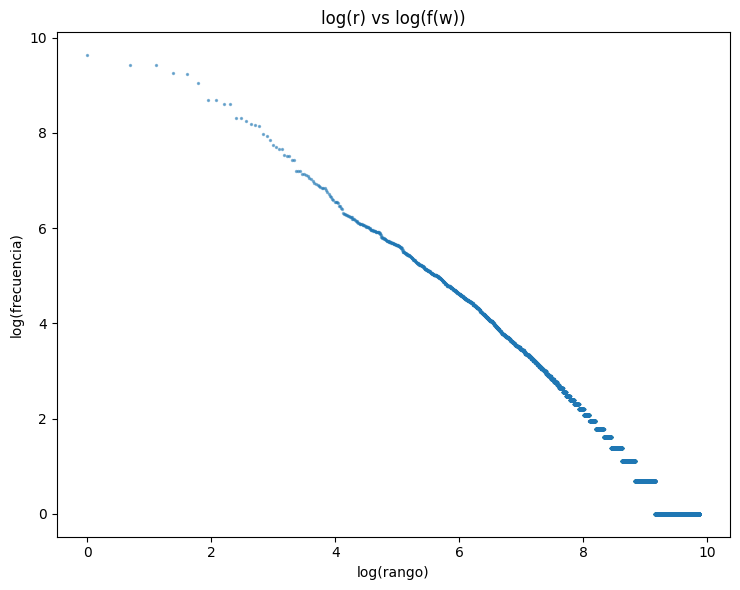

In [11]:
# Asegura carpeta de salida
os.makedirs("../data/processed", exist_ok=True)

# Dispersión completa
plt.figure(figsize=(7.5, 6))
plt.scatter(
    freq_df["log_rank"].values,
    freq_df["log_freq"].values,
    s=2, alpha=0.5, rasterized=True
)
plt.xlabel("log(rango)")
plt.ylabel("log(frecuencia)")
plt.title("log(r) vs log(f(w))")
plt.tight_layout()
plt.savefig("../reports/figures/zipf_loglog_scatter.png", dpi=200)
plt.show()

Ajusta una recta mediante regresión lineal sobre los puntos $(\log r, \log f(w))$, de la forma:

$$ \log f(r) = \log C - s \cdot \log r, $$

lo cual equivale al modelo Zipfiano $f(r) \approx \frac{C}{r^{s}}$.

Ajuste (FULL):
  s = 1.2706
  C = 1.9739e+05
  R^2 = 0.9729


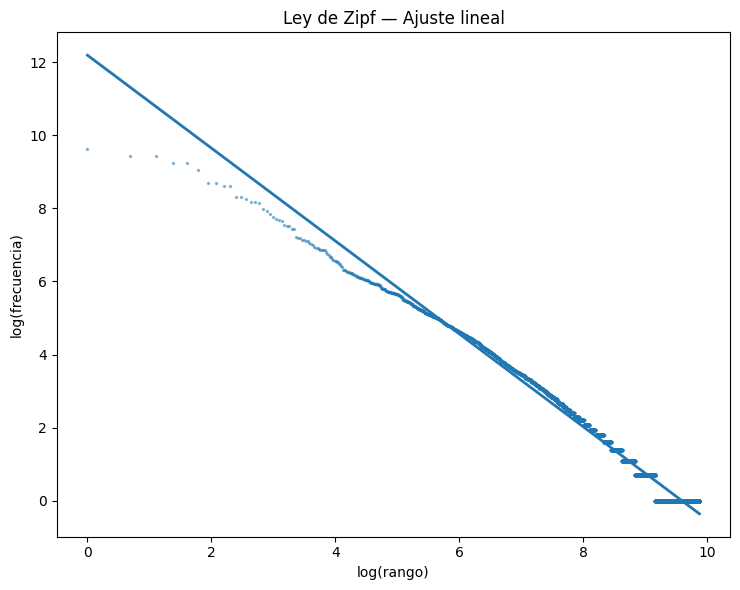

In [ ]:
# Seleccionamos las columnas
x = freq_df["log_rank"].values
y = freq_df["log_freq"].values

def linfit_and_report(x, y):
    # Ajuste lineal: y = a x + b
    a, b = np.polyfit(x, y, deg=1)
    y_hat = a * x + b
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - ss_res/ss_tot

    # Parámetros de Zipf
    s = -a                   # Pendiente negativa => s > 0
    C = float(np.exp(b))     # log C = b

    return dict(a=float(a), b=float(b), s=float(s), C=C, r2=float(r2)), y_hat

# Full fit
full_stats, y_full = linfit_and_report(x, y)
print("Ajuste (FULL):")
print(f"  s = {full_stats['s']:.4f}")
print(f"  C = {full_stats['C']:.4e}")
print(f"  R^2 = {full_stats['r2']:.4f}")

plt.figure(figsize=(7.5, 6))
plt.scatter(x, y, s=2, alpha=0.45, rasterized=True)
idx = np.argsort(x)
plt.plot(x[idx], np.array(y_full)[idx], linewidth=2)
plt.xlabel("log(rango)")
plt.ylabel("log(frecuencia)")
plt.title("Ley de Zipf — Ajuste lineal")
plt.tight_layout()
fig_full_path = "../reports/figures/zipf_fit_full.png"
plt.savefig(fig_full_path, dpi=200)
plt.show()

En esta formulación:

* $C$ es una **constante de normalización** que se aproxima a la frecuencia de la palabra más común ($f(1) \approx C$). 
* $s$ es el **exponente de Zipf**, que controla la rapidez con que decrecen las frecuencias conforme aumenta el rango. Valores cercanos a $s \approx 1$ son típicos en lenguajes naturales. 

In [ ]:
# Resumen de los resultados
def resumen_zipf(nombre, stats, freq_df):
    s = stats["s"]
    C = stats["C"]
    r2 = stats["r2"]

    # Frecuencia de la palabra más común (r=1)
    f1 = int(freq_df.loc[0, "freq"])
    err_abs = abs(C - f1)
    err_rel = err_abs / f1 * 100

    print(f"\n[{nombre}]")
    print(f"  s (pendiente con signo cambiado) = {s:.4f}")
    print(f"  C (exp(intercept))              = {C:.2f}")
    print(f"  R^2 del ajuste                  = {r2:.4f}")
    print(f"  f(1) real (token más frecuente) = {f1}")
    print(f"  |C - f(1)|                      = {err_abs:.2f}  ({err_rel:.2f}%)")

resumen_zipf("FULL", full_stats, freq_df)


[FULL]
  s (pendiente con signo cambiado) = 1.2706
  C (exp(intercept))              = 197393.45
  R^2 del ajuste                  = 0.9729
  f(1) real (token más frecuente) = 15254
  |C - f(1)|                      = 182139.45  (1194.04%)

[MIDDLE 5–95%]
  s (pendiente con signo cambiado) = 1.3373
  C (exp(intercept))              = 353496.22
  R^2 del ajuste                  = 0.9586
  f(1) real (token más frecuente) = 15254
  |C - f(1)|                      = 338242.22  (2217.40%)


## 3. Palabras importantes por clase

Elimina palabras vacı́as y normaliza el texto.

In [15]:
# Usamos la lista de stopwords que ya definimos con nltk
def clean_tokens(toks):
    return [t for t in toks if t not in stopwords_es]

# Nueva columna: tokens normalizados
df["tokens_clean"] = df["tokens"].apply(clean_tokens)
df["n_tokens_clean"] = df["tokens_clean"].apply(len)

# Ejemplo: primeras reseñas antes y después
df[["tokens", "tokens_clean", "n_tokens", "n_tokens_clean"]].head(10)

,tokens,tokens_clean,n_tokens,n_tokens_clean
0,"[un, restaurante, te, invita, por, su, ambient...","[restaurante, invita, ambiente, tan, alegre, s...",46,21
1,"[pagamos, pesos, por, la, entrada, y, no, es, ...","[pagamos, pesos, entrada, gran, cosa, único, b...",32,15
2,"[mi, esposa, y, yo, nos, alojamos, en, el, dre...","[esposa, alojamos, dreams, días, enero, primer...",134,62
3,"[la, única, decepción, puede, no, ser, josé, c...","[única, decepción, puede, ser, josé, cuervo, r...",181,88
4,"[cuando, leí, los, comentarios, sobre, cómo, s...","[leí, comentarios, cómo, cosas, grosero, creen...",117,58
5,"[durante, la, cata, compre, una, botella, de, ...","[cata, compre, botella, tequila, cofradia, rep...",57,30
6,"[la, verdad, muy, costosa, la, entrada, pesos,...","[verdad, costosa, entrada, pesos, mexicanos, p...",55,28
7,"[el, lugar, está, decorado, muy, bonito, tiene...","[lugar, decorado, bonito, mesas, interior, afu...",45,22
8,"[hace, tiempo, que, fui, al, restaurante, de, ...","[hace, tiempo, restaurante, hotel, bonito, agr...",45,17
9,"[primero, de, todo, el, hotel, está, situado, ...","[primero, hotel, situado, buena, ubicación, pe...",140,73


Identifica las palabras más frecuentes en cada clase.

In [16]:
def top_words_per_class(df, class_col, k=20):
    """
    Regresa un DataFrame con las k palabras más frecuentes por cada valor
    de `class_col`, usando la columna df['tokens_clean'].
    """
    if class_col not in df.columns:
        raise ValueError(f"No existe la columna de clase: {class_col}")
    if "tokens_clean" not in df.columns:
        raise ValueError("Falta la columna 'tokens_clean'. Ejecute la limpieza primero.")

    frames = []
    for val, g in df.groupby(class_col, dropna=False):
        c = Counter()
        for toks in g["tokens_clean"]:
            c.update(toks)
        # top-k de esta clase
        topk = c.most_common(k)
        tmp = pd.DataFrame(topk, columns=["token", "freq"])
        tmp.insert(0, "class_col", class_col)
        tmp.insert(1, "class_value", val)
        tmp["rank"] = range(1, len(tmp) + 1)
        frames.append(tmp)

    out = pd.concat(frames, ignore_index=True)
    return out[["class_col", "class_value", "rank", "token", "freq"]]

In [ ]:
# Escoge la(s) columna(s) de clase presentes
candidatas = ["Polarity", "Town", "Region", "Type"]
presentes = [c for c in candidatas if c in df.columns]

# Resultados para todas las clases presentes
tablas_por_clase = {c: top_words_per_class(df, c, k=20) for c in presentes}
for c, tabla in tablas_por_clase.items():
    print(f"\n==== Top palabras por clase: {c} ====")
    display(tabla.head(1000))



==== Top palabras por clase: Polarity ====


,class_col,class_value,rank,token,freq
0,Polarity,1.0,1,hotel,385
1,Polarity,1.0,2,lugar,328
2,Polarity,1.0,3,servicio,284
3,Polarity,1.0,4,comida,262
4,Polarity,1.0,5,habitación,250
...,...,...,...,...,...
95,Polarity,5.0,16,atención,135
96,Polarity,5.0,17,recomiendo,133
97,Polarity,5.0,18,buen,131
98,Polarity,5.0,19,experiencia,131



==== Top palabras por clase: Town ====


,class_col,class_value,rank,token,freq
0,Town,Ajijic,1,comida,55
1,Town,Ajijic,2,lugar,42
2,Town,Ajijic,3,servicio,33
3,Town,Ajijic,4,restaurante,30
4,Town,Ajijic,5,buena,25
...,...,...,...,...,...
795,Town,Zacatlan,16,menos,6
796,Town,Zacatlan,17,cuenta,6
797,Town,Zacatlan,18,q,6
798,Town,Zacatlan,19,parque,5



==== Top palabras por clase: Region ====


,class_col,class_value,rank,token,freq
0,Region,Baja_CaliforniaSur,1,comida,95
1,Region,Baja_CaliforniaSur,2,lugar,92
2,Region,Baja_CaliforniaSur,3,servicio,60
3,Region,Baja_CaliforniaSur,4,hotel,50
4,Region,Baja_CaliforniaSur,5,buena,47
...,...,...,...,...,...
375,Region,Yucatan,16,así,41
376,Region,Yucatan,17,noche,41
377,Region,Yucatan,18,habitaciones,40
378,Region,Yucatan,19,excelente,39



==== Top palabras por clase: Type ====


,class_col,class_value,rank,token,freq
0,Type,Attractive,1,lugar,649
1,Type,Attractive,2,playa,512
2,Type,Attractive,3,si,498
3,Type,Attractive,4,agua,350
4,Type,Attractive,5,ruinas,327
5,Type,Attractive,6,ver,275
6,Type,Attractive,7,pena,236
7,Type,Attractive,8,cenote,230
8,Type,Attractive,9,así,227
9,Type,Attractive,10,ir,227


Reflexiona si las palabras más repetidas son realmente discriminativas.

## 4. Patrones gramaticales (POS 4-gramas)

Etiqueta con POS cada documento.

In [ ]:
# Carga del modelo de español
nlp = spacy.load("es_core_news_sm")

def get_pos_tags(text):
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    return [token.pos_ for token in doc]

# Nueva columna con secuencia de POS por documento
df["pos_seq"] = df["Review_clean"].apply(get_pos_tags)

# Ejemplo de las primeras reseñas con sus POS
for i in range(3):
    print(f"\nDoc {i}:")
    print("Texto:", df["Review_clean"].iloc[i][:200], "...")
    print("POS:", df["pos_seq"].iloc[i][:20])


Doc 0:
Texto: Un Restaurante te invita por su ambiente tan alegre,.pero al sentarte los meseros te apuran al tomar tu orden, y luego al llevarte tu orden se olvidan de ti.
La comida esta buena.
Hay estacionamiento. ...
POS: ['DET', 'PROPN', 'PRON', 'VERB', 'ADP', 'DET', 'NOUN', 'ADV', 'PROPN', 'ADP', 'NOUN', 'DET', 'NOUN', 'PRON', 'VERB', 'ADP', 'VERB', 'DET', 'NOUN', 'PUNCT']

Doc 1:
Texto: Pagamos 25 pesos por la entrada y no es gran cosa. Lo único bueno es que no habia nadie, pero hay lugares mucho mas bonitos para bañarse en la laguna que son gratuitos. ...
POS: ['VERB', 'NUM', 'NOUN', 'ADP', 'DET', 'NOUN', 'CCONJ', 'ADV', 'AUX', 'ADJ', 'NOUN', 'PUNCT', 'PRON', 'ADJ', 'ADJ', 'AUX', 'SCONJ', 'ADV', 'VERB', 'PRON']

Doc 2:
Texto: Mi esposa y yo nos alojamos en el Dreams por 4 días en enero de 2016. Primero tengo que decir que el complejo era muy agradable y las instalaciones parecía muy bien cuidados. Teníamos una habitación c ...
POS: ['DET', 'NOUN', 'CCONJ', 'PRON', 'PRON', 'VERB'

Extrae las secuencias gramaticales más frecuentes de longitud 4 en cada clase.

In [ ]:
def extract_pos_ngrams(pos_seq, n=4):
    """Extrae n-gramas de etiquetas POS de una secuencia."""
    return [tuple(pos_seq[i:i+n]) for i in range(len(pos_seq)-n+1)]

# NUeva columna con los 4-gramas de cada doc
df["pos_4grams"] = df["pos_seq"].apply(lambda seq: extract_pos_ngrams(seq, n=4))

def top_pos_ngrams_per_class(df, class_col, k=20):
    """Devuelve los k POS 4-gramas más frecuentes por cada valor de class_col."""
    frames = []
    for val, g in df.groupby(class_col, dropna=False):
        c = Counter()
        for ngrams in g["pos_4grams"]:
            c.update(ngrams)
        topk = c.most_common(k)
        tmp = pd.DataFrame(topk, columns=["pos_4gram", "freq"])
        tmp.insert(0, "class_col", class_col)
        tmp.insert(1, "class_value", val)
        tmp["rank"] = range(1, len(tmp)+1)
        frames.append(tmp)
    return pd.concat(frames, ignore_index=True)

# Ejecutamos para todas las columnas de clase presentes
class_cols = [c for c in ["Polarity","Town","Region","Type"] if c in df.columns]

# Guardamos resultados
os.makedirs("../reports/tables", exist_ok=True)
pos_ngram_tables = {}
for col in class_cols:
    table = top_pos_ngrams_per_class(df, col, k=20)
    pos_ngram_tables[col] = table
    out_path = f"../reports/tables/top_pos4grams_{col.lower()}.csv"
    table.to_csv(out_path, index=False)
    print(f"Guardado: {out_path}")
    display(table.head(20))

Guardado: ../reports/tables/top_pos4grams_polarity.csv


,class_col,class_value,pos_4gram,freq,rank
0,Polarity,1.0,"(NOUN, ADP, DET, NOUN)",830,1
1,Polarity,1.0,"(ADP, DET, NOUN, PUNCT)",770,2
2,Polarity,1.0,"(DET, NOUN, ADP, NOUN)",690,3
3,Polarity,1.0,"(VERB, ADP, DET, NOUN)",671,4
4,Polarity,1.0,"(ADP, DET, NOUN, ADP)",527,5
5,Polarity,1.0,"(VERB, DET, NOUN, ADP)",500,6
6,Polarity,1.0,"(DET, NOUN, ADP, DET)",492,7
7,Polarity,1.0,"(NOUN, ADP, NOUN, PUNCT)",410,8
8,Polarity,1.0,"(NOUN, PUNCT, DET, NOUN)",398,9
9,Polarity,1.0,"(PRON, VERB, DET, NOUN)",343,10


Guardado: ../reports/tables/top_pos4grams_town.csv


,class_col,class_value,pos_4gram,freq,rank
0,Town,Ajijic,"(ADP, DET, NOUN, PUNCT)",110,1
1,Town,Ajijic,"(NOUN, ADP, DET, NOUN)",99,2
2,Town,Ajijic,"(DET, NOUN, ADP, NOUN)",91,3
3,Town,Ajijic,"(VERB, ADP, DET, NOUN)",72,4
4,Town,Ajijic,"(DET, NOUN, ADP, DET)",67,5
5,Town,Ajijic,"(NOUN, PUNCT, DET, NOUN)",59,6
6,Town,Ajijic,"(ADJ, PUNCT, DET, NOUN)",57,7
7,Town,Ajijic,"(ADP, DET, NOUN, ADP)",56,8
8,Town,Ajijic,"(PUNCT, DET, NOUN, AUX)",56,9
9,Town,Ajijic,"(DET, NOUN, AUX, ADJ)",56,10


Guardado: ../reports/tables/top_pos4grams_region.csv


,class_col,class_value,pos_4gram,freq,rank
0,Region,Baja_CaliforniaSur,"(NOUN, ADP, DET, NOUN)",245,1
1,Region,Baja_CaliforniaSur,"(ADP, DET, NOUN, PUNCT)",222,2
2,Region,Baja_CaliforniaSur,"(DET, NOUN, ADP, NOUN)",190,3
3,Region,Baja_CaliforniaSur,"(ADP, DET, NOUN, ADP)",165,4
4,Region,Baja_CaliforniaSur,"(DET, NOUN, ADP, DET)",159,5
5,Region,Baja_CaliforniaSur,"(VERB, ADP, DET, NOUN)",147,6
6,Region,Baja_CaliforniaSur,"(NOUN, ADP, NOUN, PUNCT)",110,7
7,Region,Baja_CaliforniaSur,"(VERB, DET, NOUN, ADP)",103,8
8,Region,Baja_CaliforniaSur,"(DET, NOUN, AUX, ADJ)",102,9
9,Region,Baja_CaliforniaSur,"(DET, NOUN, ADJ, PUNCT)",99,10


Guardado: ../reports/tables/top_pos4grams_type.csv


,class_col,class_value,pos_4gram,freq,rank
0,Type,Attractive,"(NOUN, ADP, DET, NOUN)",1592,1
1,Type,Attractive,"(ADP, DET, NOUN, PUNCT)",1344,2
2,Type,Attractive,"(DET, NOUN, ADP, NOUN)",1172,3
3,Type,Attractive,"(ADP, DET, NOUN, ADP)",1139,4
4,Type,Attractive,"(VERB, ADP, DET, NOUN)",1121,5
5,Type,Attractive,"(DET, NOUN, ADP, DET)",1012,6
6,Type,Attractive,"(VERB, DET, NOUN, ADP)",765,7
7,Type,Attractive,"(NOUN, ADP, NOUN, PUNCT)",682,8
8,Type,Attractive,"(NOUN, PUNCT, DET, NOUN)",646,9
9,Type,Attractive,"(ADJ, ADP, DET, NOUN)",584,10


Discute si estas estructuras difieren entre clases y explica por qué.

## 5. Representaciones BoW

Construye representaciones BoW con TF y con TF-IDF.

In [21]:
# Función de preprocesamiento: usamos tokens_clean unidos por espacio
docs_clean = df["tokens_clean"].apply(lambda toks: " ".join(toks)).tolist()

# --- BoW con TF (frecuencia absoluta) ---
vectorizer_tf = CountVectorizer()
X_tf = vectorizer_tf.fit_transform(docs_clean)

# --- BoW con TF-IDF ---
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(docs_clean)

# --- Info básica ---
print("Matriz TF:")
print(f"  Forma: {X_tf.shape} (docs x vocabulario)")
print("Matriz TF-IDF:")
print(f"  Forma: {X_tfidf.shape} (docs x vocabulario)")

# Vocabulario (tokens -> índice)
vocab = vectorizer_tf.get_feature_names_out()
print(f"Tamaño vocabulario: {len(vocab)}")


Matriz TF:
  Forma: (5000, 19157) (docs x vocabulario)
Matriz TF-IDF:
  Forma: (5000, 19157) (docs x vocabulario)
Tamaño vocabulario: 19157


Aplica alguna medida estadística (chi-cuadrado, información mutua o information gain).

In [ ]:

CLASS_COL = "Polarity"   # seleccionar: "Polarity" | "Type" | "Town" | "Region"
y_raw = df[CLASS_COL].astype(str).values
le = LabelEncoder()
y = le.fit_transform(y_raw)
classes = le.classes_

vocab = np.array(vectorizer_tf.get_feature_names_out())

def chi2_global(X, vocab, topk=20):
    scores, pvals = chi2(X, y)
    idx = np.argsort(scores)[::-1][:topk]
    return pd.DataFrame({"token": vocab[idx], "chi2": scores[idx], "p_value": pvals[idx]})

def chi2_ovr(X, vocab, topk=20):
    frames = []
    for cls_idx, cls_name in enumerate(classes):
        y_bin = (y == cls_idx).astype(int)
        scores, pvals = chi2(X, y_bin)
        idx = np.argsort(scores)[::-1][:topk]
        frames.append(pd.DataFrame({
            "class": cls_name, "token": vocab[idx],
            "chi2": scores[idx], "p_value": pvals[idx]
        }))
    return pd.concat(frames, ignore_index=True)

print(f"=== χ² (TF) — Clase: {CLASS_COL} ===")
chi2_global_tf = chi2_global(X_tf, vocab, 20);  display(chi2_global_tf)
chi2_ovr_tf    = chi2_ovr(X_tf,    vocab, 20);  display(chi2_ovr_tf)

print(f"=== χ² (TF-IDF) — Clase: {CLASS_COL} ===")
chi2_global_tfidf = chi2_global(X_tfidf, vocab, 20);  display(chi2_global_tfidf)
chi2_ovr_tfidf    = chi2_ovr(X_tfidf,    vocab, 20);  display(chi2_ovr_tfidf)

=== χ² (TF) — Clase: Polarity ===


,token,chi2,p_value
0,habitación,270.795511,2.149360e-57
1,excelente,265.189844,3.471739e-56
2,peor,256.452655,2.650724e-54
3,mala,245.876086,5.033742e-52
4,mal,242.179091,3.148887e-51
5,hotel,230.102897,1.254416e-48
6,pésimo,192.413565,1.605543e-40
7,dijeron,185.812247,4.208013e-39
8,increíble,174.593663,1.079973e-36
9,dijo,142.265033,9.239992e-30


,class,token,chi2,p_value
0,1.0,peor,210.575811,1.028587e-47
1,1.0,pésimo,173.220626,1.464830e-39
2,1.0,mala,133.398601,7.396555e-31
3,1.0,dijeron,125.148810,4.721767e-29
4,1.0,pésima,105.813629,8.100654e-25
...,...,...,...,...
95,5.0,peor,43.881660,3.488424e-11
96,5.0,atento,39.930414,2.631732e-10
97,5.0,habitaciones,38.880418,4.505779e-10
98,5.0,pedimos,38.107924,6.693773e-10


=== χ² (TF-IDF) — Clase: Polarity ===


,token,chi2,p_value
0,excelente,44.146264,5.982286e-09
1,mala,32.792962,1.316922e-06
2,pésimo,32.363782,1.612000e-06
3,peor,31.438250,2.491635e-06
4,mal,26.591277,2.404258e-05
5,deliciosa,26.167820,2.927207e-05
6,pésima,21.704921,2.294271e-04
7,increíble,21.593861,2.413914e-04
8,gracias,20.011877,4.967103e-04
9,regular,19.552423,6.119436e-04


,class,token,chi2,p_value
0,1.0,pésimo,29.539740,5.478187e-08
1,1.0,peor,26.445023,2.711461e-07
2,1.0,pésima,19.641692,9.340857e-06
3,1.0,mala,17.430592,2.979912e-05
4,1.0,horrible,11.952098,5.458587e-04
...,...,...,...,...
95,5.0,excepcional,7.032314,8.005184e-03
96,5.0,exelente,6.792698,9.153149e-03
97,5.0,impecable,6.687635,9.708389e-03
98,5.0,embargo,6.630233,1.002622e-02


Obtén el top 20 de características más importantes en cada representación.

In [ ]:
# Top-20 características más importantes (χ²) en TF y TF-IDF

def chi2_ranking(X, vocab, y, classes, topk=20):
    """Devuelve ranking global y one-vs-rest (topk) con chi2."""
    # Global
    scores, pvals = chi2(X, y)
    idx = np.argsort(scores)[::-1][:topk]
    global_rank = pd.DataFrame({
        "token": vocab[idx],
        "chi2": scores[idx],
        "p_value": pvals[idx]
    })

    # One-vs-Rest
    frames = []
    for cls_idx, cls_name in enumerate(classes):
        y_bin = (y == cls_idx).astype(int)
        scores, pvals = chi2(X, y_bin)
        idx = np.argsort(scores)[::-1][:topk]
        tmp = pd.DataFrame({
            "class": cls_name,
            "token": vocab[idx],
            "chi2": scores[idx],
            "p_value": pvals[idx]
        })
        frames.append(tmp)
    ovr_rank = pd.concat(frames, ignore_index=True)

    return global_rank, ovr_rank

# Asegura carpeta de salida
os.makedirs("../reports/tables", exist_ok=True)

# Vocabulario
vocab = np.array(vectorizer_tf.get_feature_names_out())

# Rankings con TF
chi2_global_tf, chi2_ovr_tf = chi2_ranking(X_tf, vocab, y, classes, topk=20)
chi2_global_tf.to_csv("../reports/tables/top20_chi2_global_tf.csv", index=False)
chi2_ovr_tf.to_csv("../reports/tables/top20_chi2_ovr_tf.csv", index=False)

# Rankings con TF-IDF
chi2_global_tfidf, chi2_ovr_tfidf = chi2_ranking(X_tfidf, vocab, y, classes, topk=20)
chi2_global_tfidf.to_csv("../reports/tables/top20_chi2_global_tfidf.csv", index=False)
chi2_ovr_tfidf.to_csv("../reports/tables/top20_chi2_ovr_tfidf.csv", index=False)

print("Archivos guardados en ../reports/tables/:")
print(" - top20_chi2_global_tf.csv")
print(" - top20_chi2_ovr_tf.csv")
print(" - top20_chi2_global_tfidf.csv")
print(" - top20_chi2_ovr_tfidf.csv")

# Mostrar un vistazo
display(chi2_global_tf.head(20))
display(chi2_global_tfidf.head(20))


Archivos guardados en ../reports/tables/:
 - top20_chi2_global_tf.csv
 - top20_chi2_ovr_tf.csv
 - top20_chi2_global_tfidf.csv
 - top20_chi2_ovr_tfidf.csv


,token,chi2,p_value
0,habitación,270.795511,2.149360e-57
1,excelente,265.189844,3.471739e-56
2,peor,256.452655,2.650724e-54
3,mala,245.876086,5.033742e-52
4,mal,242.179091,3.148887e-51
5,hotel,230.102897,1.254416e-48
6,pésimo,192.413565,1.605543e-40
7,dijeron,185.812247,4.208013e-39
8,increíble,174.593663,1.079973e-36
9,dijo,142.265033,9.239992e-30


,token,chi2,p_value
0,excelente,44.146264,5.982286e-09
1,mala,32.792962,1.316922e-06
2,pésimo,32.363782,1.612000e-06
3,peor,31.438250,2.491635e-06
4,mal,26.591277,2.404258e-05
5,deliciosa,26.167820,2.927207e-05
6,pésima,21.704921,2.294271e-04
7,increíble,21.593861,2.413914e-04
8,gracias,20.011877,4.967103e-04
9,regular,19.552423,6.119436e-04


## 6. Bigramas

Repite el ejercicio anterior pero utilizando bigramas de palabras. Compara resultados y discute si los bigramas aportan mayor discriminación semántica.

In [ ]:
# Parámetros
CLASS_COL = "Polarity"   # Seleccionar variable
TOPK = 20
MIN_DF = 3               # Filtra bigramas ultra-raros

# Docs (desde tokens_clean)
docs_clean = df["tokens_clean"].apply(lambda toks: " ".join(toks)).tolist()

# Vectorizadores SOLO bigramas
vectorizer_bigram_tf = CountVectorizer(ngram_range=(2,2), min_df=MIN_DF)
X_bigram_tf = vectorizer_bigram_tf.fit_transform(docs_clean)

vectorizer_bigram_tfidf = TfidfVectorizer(ngram_range=(2,2), min_df=MIN_DF)
X_bigram_tfidf = vectorizer_bigram_tfidf.fit_transform(docs_clean)

vocab_bi_tf = np.array(vectorizer_bigram_tf.get_feature_names_out())
vocab_bi_tfidf = np.array(vectorizer_bigram_tfidf.get_feature_names_out())

print("Formas:")
print("  X_bigram_tf:    ", X_bigram_tf.shape)
print("  X_bigram_tfidf: ", X_bigram_tfidf.shape)

# Etiquetas
y_raw = df[CLASS_COL].astype(str).values
le = LabelEncoder()
y = le.fit_transform(y_raw)
classes = le.classes_

def chi2_ranking(X, vocab, y, classes, topk=TOPK):
    """Devuelve ranking global y one-vs-rest (topk) con chi2."""
    # Global
    scores, pvals = chi2(X, y)
    idx = np.argsort(scores)[::-1][:topk]
    global_rank = pd.DataFrame({
        "token_or_bigram": vocab[idx],
        "chi2": scores[idx],
        "p_value": pvals[idx]
    })
    # One-vs-Rest
    frames = []
    for cls_idx, cls_name in enumerate(classes):
        y_bin = (y == cls_idx).astype(int)
        scores, pvals = chi2(X, y_bin)
        idx = np.argsort(scores)[::-1][:topk]
        frames.append(pd.DataFrame({
            "class": cls_name,
            "token_or_bigram": vocab[idx],
            "chi2": scores[idx],
            "p_value": pvals[idx]
        }))
    ovr_rank = pd.concat(frames, ignore_index=True)
    return global_rank, ovr_rank

# Rankings χ² con BIGRAMAS (TF y TF-IDF)
chi2_global_bi_tf, chi2_ovr_bi_tf = chi2_ranking(X_bigram_tf, vocab_bi_tf, y, classes, TOPK)
chi2_global_bi_tfidf, chi2_ovr_bi_tfidf = chi2_ranking(X_bigram_tfidf, vocab_bi_tfidf, y, classes, TOPK)

# Guardar tablas
os.makedirs("../reports/tables", exist_ok=True)
chi2_global_bi_tf.to_csv("../reports/tables/top20_chi2_global_bigram_tf.csv", index=False)
chi2_ovr_bi_tf.to_csv("../reports/tables/top20_chi2_ovr_bigram_tf.csv", index=False)
chi2_global_bi_tfidf.to_csv("../reports/tables/top20_chi2_global_bigram_tfidf.csv", index=False)
chi2_ovr_bi_tfidf.to_csv("../reports/tables/top20_chi2_ovr_bigram_tfidf.csv", index=False)

print("Guardado en ../reports/tables/:")
print(" - top20_chi2_global_bigram_tf.csv")
print(" - top20_chi2_ovr_bigram_tf.csv")
print(" - top20_chi2_global_bigram_tfidf.csv")
print(" - top20_chi2_ovr_bigram_tfidf.csv")

# Vistazo rápido
display(chi2_global_bi_tf.head(20))
display(chi2_global_bi_tfidf.head(20))

Formas:
  X_bigram_tf:     (5000, 5567)
  X_bigram_tfidf:  (5000, 5567)
Guardado en ../reports/tables/:
 - top20_chi2_global_bigram_tf.csv
 - top20_chi2_ovr_bigram_tf.csv
 - top20_chi2_global_bigram_tfidf.csv
 - top20_chi2_ovr_bigram_tfidf.csv


,token_or_bigram,chi2,p_value
0,pésimo servicio,73.780059,3.609016e-15
1,excelente servicio,72.694287,6.122004e-15
2,mala experiencia,70.458421,1.816381e-14
3,mal servicio,68.483726,4.742493e-14
4,comida deliciosa,66.358405,1.331120e-13
5,servicio pésimo,48.333333,8.042216e-10
6,peor experiencia,46.323232,2.109424e-09
7,comida mala,39.406987,5.740176e-08
8,recomiendo encarecidamente,36.572844,2.205766e-07
9,peor hotel,36.061728,2.810306e-07


,token_or_bigram,chi2,p_value
0,pésimo servicio,34.650492,5.480132e-07
1,excelente servicio,30.294368,4.263422e-06
2,mala experiencia,26.256090,2.809600e-05
3,comida deliciosa,24.706625,5.762535e-05
4,mal servicio,23.223136,1.142692e-04
5,servicio pésimo,23.123632,1.196244e-04
6,peor experiencia,17.932273,1.272281e-03
7,tardaron minutos,17.091321,1.855551e-03
8,comida mala,16.019949,2.992511e-03
9,comida horrible,13.733956,8.194403e-03


## 7. Word2Vec y analogı́as

Entrena un modelo Word2Vec sobre el corpus.

In [53]:
# ===============================================
# Entrenamiento Word2Vec sobre el corpus limpio
# ===============================================

# Usamos la columna tokens_clean como corpus de oraciones
sentences = df["tokens_clean"].tolist()

# Configuración del modelo
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,   # dimensión de los embeddings
    window=5,          # contexto: 5 palabras a izquierda/derecha
    min_count=3,       # ignora palabras con frecuencia < 3
    sg=1,              # 1 = Skip-gram, 0 = CBOW
    workers=4,         # hilos paralelos
    epochs=10,         # número de pasadas sobre el corpus
    seed=42
)

# Acceso al vocabulario
print("Tamaño del vocabulario entrenado:", len(w2v_model.wv))



Tamaño del vocabulario entrenado: 6700


Realiza al menos 5 analogías interesantes y discute los resultados.

In [ ]:
# ============================================================
# Analogías con Word2Vec
# ============================================================
import numpy as np
import pandas as pd
from collections import defaultdict

wv = w2v_model.wv
V  = set(wv.index_to_key)  # vocab entrenado

def in_vocab(token):
    return token in V

def try_analogy(positives, negatives, topn=10):
    """
    positives: lista de tokens (+)
    negatives: lista de tokens (-)
    Retorna DataFrame con topn similares o None si falta vocab.
    """
    # Checa vocabulario
    missing = [t for t in positives + negatives if not in_vocab(t)]
    if missing:
        return None, missing

    res = wv.most_similar(positive=positives, negative=negatives, topn=topn)
    df_res = pd.DataFrame(res, columns=["word", "cosine"])
    df_res.insert(0, "pos", [" + ".join(positives)]*len(df_res))
    df_res.insert(1, "neg", [" - ".join(negatives)]*len(df_res))
    return df_res, []

# Lista de analogías candidatas (dominio reseñas / turismo)
analogies = [
    # Relaciones de Partes a un Todo (más directas)
    (["restaurante", "comida"], ["hotel"]),
    (["habitación", "hotel"], ["comida"]),

    # Relaciones de Atributos y Cualidades
    (["servicio", "excelente"], ["comida"]),
    (["servicio", "malo"], ["comida"]),

    # Relaciones de Ubicación y Actividad
    (["playa", "nadar"], ["cenote"]),

    # Relaciones de Ubicación y Cultura/Producto
    (["tequila", "jalisco"], ["mezcal"]),

    # Relaciones de Oposición (antónimos)
    (["caro", "malo"], ["barato"]),
    (["limpio", "sucio"], ["amable"]),
    (["paz", "tranquilidad"], ["ruido"]),

    # Relaciones de Lugares y sus Atributos
    (["cenote", "agua"], ["playa"]),
    (["pirámide", "maya"], ["ruinas"]),
]

# Ejecuta y colecciona
results = []
skipped = []

for pos, neg in analogies:
    df_res, miss = try_analogy(pos, neg, topn=10)
    if df_res is None:
        skipped.append({"pos": " + ".join(pos), "neg": " - ".join(neg), "missing": miss})
        continue
    results.append(df_res)
    # Print
    print(f"\nAnalogía: ({' + '.join(pos)}) - ({' - '.join(neg)})")
    display(df_res.head(10))

# Combina resultados exitosos
if results:
    analogies_df = pd.concat(results, ignore_index=True)
    # Guarda para el reporte
    out_path = "../reports/tables/word2vec_analogies.csv"
    analogies_df.to_csv(out_path, index=False)
    print(f"\nGuardado: {out_path}")



Analogía: (restaurante + comida) - (hotel)


,pos,neg,word,cosine
0,restaurante + comida,hotel,presentada,0.669383
1,restaurante + comida,hotel,típico,0.665704
2,restaurante + comida,hotel,casera,0.662096
3,restaurante + comida,hotel,variado,0.661807
4,restaurante + comida,hotel,presentación,0.657930
5,restaurante + comida,hotel,mariachi,0.655680
6,restaurante + comida,hotel,casero,0.652844
7,restaurante + comida,hotel,abundantes,0.652660
8,restaurante + comida,hotel,lento,0.650533
9,restaurante + comida,hotel,gustos,0.649080



Analogía: (habitación + hotel) - (comida)


,pos,neg,word,cosine
0,habitación + hotel,comida,com,0.656843
1,habitación + hotel,comida,booking,0.642220
2,habitación + hotel,comida,reservamos,0.629496
3,habitación + hotel,comida,suite,0.610207
4,habitación + hotel,comida,noches,0.604475
5,habitación + hotel,comida,reservé,0.601576
6,habitación + hotel,comida,reservado,0.601132
7,habitación + hotel,comida,edificio,0.600339
8,habitación + hotel,comida,villa,0.593378
9,habitación + hotel,comida,piso,0.590269



Analogía: (servicio + excelente) - (comida)


,pos,neg,word,cosine
0,servicio + excelente,comida,hospedarse,0.574247
1,servicio + excelente,comida,exquisita,0.561465
2,servicio + excelente,comida,inmejorable,0.558496
3,servicio + excelente,comida,llama,0.556153
4,servicio + excelente,comida,súper,0.554182
5,servicio + excelente,comida,atenta,0.553303
6,servicio + excelente,comida,anteriormente,0.551270
7,servicio + excelente,comida,atencion,0.543447
8,servicio + excelente,comida,impecable,0.542407
9,servicio + excelente,comida,bernal,0.541861



Analogía: (servicio + malo) - (comida)


,pos,neg,word,cosine
0,servicio + malo,comida,aceptable,0.664709
1,servicio + malo,comida,valet,0.659964
2,servicio + malo,comida,groseros,0.647019
3,servicio + malo,comida,atenderte,0.639250
4,servicio + malo,comida,tardado,0.635939
5,servicio + malo,comida,comunicación,0.633399
6,servicio + malo,comida,tardan,0.630252
7,servicio + malo,comida,deficiente,0.626020
8,servicio + malo,comida,empleados,0.625056
9,servicio + malo,comida,restaurant,0.618586



Analogía: (playa + nadar) - (cenote)


,pos,neg,word,cosine
0,playa + nadar,cenote,arena,0.700225
1,playa + nadar,cenote,sombrillas,0.688391
2,playa + nadar,cenote,algas,0.672801
3,playa + nadar,cenote,olas,0.671866
4,playa + nadar,cenote,preciosa,0.662842
5,playa + nadar,cenote,sombra,0.652517
6,playa + nadar,cenote,blanca,0.633278
7,playa + nadar,cenote,rompiendo,0.631493
8,playa + nadar,cenote,jugar,0.629341
9,playa + nadar,cenote,palmeras,0.620571



Analogía: (tequila + jalisco) - (mezcal)


,pos,neg,word,cosine
0,tequila + jalisco,mezcal,encontrarás,0.851684
1,tequila + jalisco,mezcal,quintana,0.842224
2,tequila + jalisco,mezcal,remedios,0.841447
3,tequila + jalisco,mezcal,maravillas,0.840091
4,tequila + jalisco,mezcal,patzcuaro,0.839711
5,tequila + jalisco,mezcal,recorrimos,0.833520
6,tequila + jalisco,mezcal,spratling,0.832180
7,tequila + jalisco,mezcal,roo,0.826079
8,tequila + jalisco,mezcal,mariposa,0.826071
9,tequila + jalisco,mezcal,divino,0.825454



Analogía: (caro + malo) - (barato)


,pos,neg,word,cosine
0,caro + malo,barato,deficiente,0.777827
1,caro + malo,barato,pésimo,0.768254
2,caro + malo,barato,tardado,0.735519
3,caro + malo,barato,pesimo,0.725779
4,caro + malo,barato,regular,0.724241
5,caro + malo,barato,pesima,0.717526
6,caro + malo,barato,tardan,0.715861
7,caro + malo,barato,atenderte,0.703850
8,caro + malo,barato,escasa,0.689469
9,caro + malo,barato,lenta,0.684625



Analogía: (limpio + sucio) - (amable)


,pos,neg,word,cosine
0,limpio + sucio,amable,descuidado,0.778405
1,limpio + sucio,amable,viejo,0.774193
2,limpio + sucio,amable,huele,0.765678
3,limpio + sucio,amable,armario,0.754061
4,limpio + sucio,amable,ventilador,0.749055
5,limpio + sucio,amable,colchón,0.734807
6,limpio + sucio,amable,feo,0.733946
7,limpio + sucio,amable,mobiliario,0.728386
8,limpio + sucio,amable,paredes,0.727475
9,limpio + sucio,amable,cortina,0.724823



Analogía: (paz + tranquilidad) - (ruido)


,pos,neg,word,cosine
0,paz + tranquilidad,ruido,naturaleza,0.830994
1,paz + tranquilidad,ruido,arquitectura,0.828772
2,paz + tranquilidad,ruido,belleza,0.820304
3,paz + tranquilidad,ruido,ampliamente,0.819280
4,paz + tranquilidad,ruido,encuentras,0.810980
5,paz + tranquilidad,ruido,conocimiento,0.809766
6,paz + tranquilidad,ruido,medicina,0.804817
7,paz + tranquilidad,ruido,altamente,0.804740
8,paz + tranquilidad,ruido,respira,0.804428
9,paz + tranquilidad,ruido,cultura,0.803183



Analogía: (cenote + agua) - (playa)


,pos,neg,word,cosine
0,cenote + agua,playa,nadar,0.493936
1,cenote + agua,playa,lleve,0.481890
2,cenote + agua,playa,chalecos,0.472163
3,cenote + agua,playa,tortugas,0.471210
4,cenote + agua,playa,salvavidas,0.470920
5,cenote + agua,playa,gorra,0.455530
6,cenote + agua,playa,cuevas,0.450353
7,cenote + agua,playa,llevar,0.449754
8,cenote + agua,playa,solar,0.447839
9,cenote + agua,playa,peces,0.445067



Analogía: (pirámide + maya) - (ruinas)


,pos,neg,word,cosine
0,pirámide + maya,ruinas,exposición,0.735582
1,pirámide + maya,ruinas,remedios,0.728412
2,pirámide + maya,ruinas,admirar,0.727883
3,pirámide + maya,ruinas,imperdible,0.727635
4,pirámide + maya,ruinas,patzcuaro,0.714821
5,pirámide + maya,ruinas,templo,0.712605
6,pirámide + maya,ruinas,fortaleza,0.711277
7,pirámide + maya,ruinas,cultural,0.710872
8,pirámide + maya,ruinas,quintana,0.707114
9,pirámide + maya,ruinas,país,0.694918



Guardado: ../reports/tables/word2vec_analogies.csv


## 8. Embeddings de documento y clusterización

Calcula embeddings de documentos como el promedio de Word2Vec.

In [30]:
# ===============================================
# Embeddings de documentos = promedio de Word2Vec
# ===============================================

wv = w2v_model.wv
dim = wv.vector_size

def doc_embedding(tokens):
    """Devuelve el embedding promedio de los tokens presentes en el vocabulario."""
    valid = [wv[t] for t in tokens if t in wv]
    if not valid:
        return np.zeros(dim)  # documento vacío o sin tokens en vocab
    return np.mean(valid, axis=0)

# Calculamos embeddings de todos los documentos
doc_embeddings = np.vstack(df["tokens_clean"].apply(doc_embedding).values)

print("Forma de la matriz de embeddings:", doc_embeddings.shape)


Forma de la matriz de embeddings: (5000, 300)


Aplica K-means con $k=5$.

In [32]:
# ===============================================
# K-means clustering con k=5 sobre embeddings
# ===============================================

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(doc_embeddings)

# Guardamos cluster asignado en el DataFrame
df["cluster"] = clusters

# Información general
print("Inercia (suma de distancias al centroide):", kmeans.inertia_)
print("Tamaño de cada cluster:")
print(df["cluster"].value_counts().sort_index())


Inercia (suma de distancias al centroide): 1700.615478515625
Tamaño de cada cluster:
cluster
0    1071
1     796
2     991
3     764
4    1378
Name: count, dtype: int64


Reporta los 5 textos más cercanos al centroide de cada clúster.

In [33]:
# ============================================================
# Top-5 textos más cercanos al centroide de cada clúster
# ============================================================

def closest_docs_to_centroid(cluster_id, topn=5):
    """Devuelve índices y distancias de los top-n docs más cercanos al centroide."""
    centroid = kmeans.cluster_centers_[cluster_id]
    dists = np.linalg.norm(doc_embeddings - centroid, axis=1)
    idx_sorted = np.argsort(dists)
    return idx_sorted[:topn], dists[idx_sorted[:topn]]

# Mostrar resultados
for c in range(k):
    idxs, dists = closest_docs_to_centroid(c, topn=5)
    print(f"\n=== Cluster {c} (top 5 docs cercanos al centroide) ===")
    for rank, (i, d) in enumerate(zip(idxs, dists), start=1):
        print(f"{rank}. Dist={d:.4f} | DocID={i}")
        print("   ", df["Review_clean"].iloc[i][:200].replace("\n"," "), "...")



=== Cluster 0 (top 5 docs cercanos al centroide) ===
1. Dist=0.2751 | DocID=2984
    Cuando se viaja mis preocupaciones principales son tranquilidad, comodidad y limpieza. si el personal es amable o no realmente no me importa mientras que realizan su función. El personal de este hotel ...
2. Dist=0.2777 | DocID=154
    El hotel esta situado en un entorno magnifico, jardines y piscina muy cuidados, las habitaciones requerirían una reforma, sobre todo los baños, duchas con cortina, falta de ganchos para colgar las toa ...
3. Dist=0.2793 | DocID=1344
    Estoy tentado a dar Rancho encantado una crítica de cinco estrellas, simplemente porque su personal es el mejor. Todo el mundo te pide que te lo estás, desde la recepción hasta los jardineros. Realmen ...
4. Dist=0.2842 | DocID=3167
    Este hotel tiene su encanto, pero están perdiendo la mark en unos pocos lugares. Muy amable y competente, 2 restaurantes en el hotel con buena comida (aunque el servicio fue extremadamente lento una n ...

In [ ]:
# Guardamos resultados
os.makedirs("../reports/tables", exist_ok=True)

rows = []
for c in range(k):
    centroid = kmeans.cluster_centers_[c]
    dists = np.linalg.norm(doc_embeddings - centroid, axis=1)
    idx_sorted = np.argsort(dists)
    top_idx = idx_sorted[:5]
    for rank, i in enumerate(top_idx, start=1):
        rows.append({
            "cluster": c,
            "rank": rank,
            "doc_id": i,
            "distance": float(dists[i]),
            "text": df["Review_clean"].iloc[i]
        })

cluster_top_docs = pd.DataFrame(rows)
out_path = "../reports/tables/cluster_top_docs.csv"
cluster_top_docs.to_csv(out_path, index=False)

print(f"Guardado en {out_path}")
display(cluster_top_docs.head(15))

Guardado en ../reports/tables/cluster_top_docs.csv


,cluster,rank,doc_id,distance,text
0,0,1,2984,0.275084,Cuando se viaja mis preocupaciones principales...
1,0,2,154,0.277740,"El hotel esta situado en un entorno magnifico,..."
2,0,3,1344,0.279269,Estoy tentado a dar Rancho encantado una críti...
3,0,4,3167,0.284237,"Este hotel tiene su encanto, pero están perdie..."
4,0,5,857,0.286914,"Cuando reservé este hotel, tenía una calificac..."
5,1,1,1186,0.243066,"NO VAYAN A CASA CENOTE!!!El dueño, GARY es un ..."
6,1,2,2441,0.258653,"Empezando por lo malo, el servicio no está a l..."
7,1,3,1994,0.261971,Cuidado con sus platillos en el restaurante Or...
8,1,4,3304,0.271702,Estamos de acuerdo con los comentarios que dic...
9,1,5,3419,0.278683,Hoy 1 de junio del 2017 fui a comer con mi mam...


Discute si los clústeres se alinean con las etiquetas originales.

## 9. Clasificación con partición 70/30


Realiza cuatro experimentos acumulativos con un clasificador (SVM o regresión logística):

1.  Sin preprocesamiento.
2.  Con minúsculas.
3.  Con minúsculas y stemming/lematización.
4.  Con minúsculas, stemming y filtrando palabras con una frecuencia mínima de 10.

In [ ]:
#classifier = LinearSVC(random_state=42) # Para usar SVM

# Elegir la columna de clase
CLASS_COL = "Polarity"
TEXT_COL  = "Review_clean"  # usamos texto limpio de mojibake

# Train/Test 70/30 estratificado
X = df[TEXT_COL].astype(str).values
y = df[CLASS_COL].astype(str).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Regex para tokens en español
WORD_RE = re.compile(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]{2,}(?:[-'][A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+)?")

def tokenize_basic(text: str, lower: bool = False):
    if not isinstance(text, str):
        return []
    if lower:
        text = text.lower()
    return WORD_RE.findall(text)

# Stemming (Snowball en español)
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("spanish")

def tokenizer_stem(text: str):
    toks = tokenize_basic(text, lower=True)
    return [stemmer.stem(t) for t in toks]

# Lemmatización con spaCy
USE_LEMMA = False
if USE_LEMMA:
    import spacy
    try:
        nlp = spacy.load("es_core_news_sm")
    except OSError:
        raise RuntimeError("Falta el modelo de spaCy: ejecuta `python -m spacy download es_core_news_sm`")

    def tokenizer_lemma(text: str):
        if not isinstance(text, str):
            return []
        doc = nlp(text.lower())
        # Lemmas alfabéticos (sin signos) y >1 char
        return [t.lemma_ for t in doc if t.is_alpha and len(t) > 1]

In [38]:
from sklearn.metrics import confusion_matrix

def run_experiment(name: str, vectorizer, classifier=None):
    """
    Entrena con X_train/y_train, evalúa en X_test/y_test y retorna dict de métricas.
    """
    if classifier is None:
        classifier = LogisticRegression(max_iter=2000, multi_class="auto", n_jobs=None, random_state=42)

    Xtr = vectorizer.fit_transform(X_train)
    Xte = vectorizer.transform(X_test)

    clf = classifier.fit(Xtr, y_train)
    y_pred = clf.predict(Xte)

    acc  = accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average="macro")
    f1w  = f1_score(y_test, y_pred, average="weighted")

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | F1-macro: {f1m:.4f} | F1-weighted: {f1w:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    cm_df = pd.DataFrame(cm, index=clf.classes_, columns=clf.classes_)
    print("\nMatriz de confusión:")
    display(cm_df)

    # Plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión - {name}")
    plt.ylabel("Etiqueta real")
    plt.xlabel("Predicción")
    plt.show()

    # Guardar CSV
    out_path = f"../reports/tables/confusion_matrix_{name.replace(' ', '_')}.csv"
    cm_df.to_csv(out_path)
    print(f"Guardada en {out_path}")

    return {
        "name": name,
        "accuracy": acc,
        "f1_macro": f1m,
        "f1_weighted": f1w,
        "vectorizer": vectorizer,
        "classifier": clf
    }


/home/diego23/Master/cimat/language-image-processing/nlp/01_Corpus_Analysis/.nlpvenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== (a) Sin preproc ===
Accuracy: 0.4933 | F1-macro: 0.4822 | F1-weighted: 0.4856

Classification report:
              precision    recall  f1-score   support

         1.0     0.5410    0.5500    0.5455       240
         2.0     0.4476    0.3481    0.3917       270
         3.0     0.4618    0.4233    0.4417       300
         4.0     0.4235    0.3939    0.4082       330
         5.0     0.5539    0.7139    0.6238       360

    accuracy                         0.4933      1500
   macro avg     0.4856    0.4859    0.4822      1500
weighted avg     0.4856    0.4933    0.4856      1500


Matriz de confusión:


,1.0,2.0,3.0,4.0,5.0
1.0,132,50,26,13,19
2.0,84,94,53,20,19
3.0,21,43,127,69,40
4.0,5,18,48,130,129
5.0,2,5,21,75,257


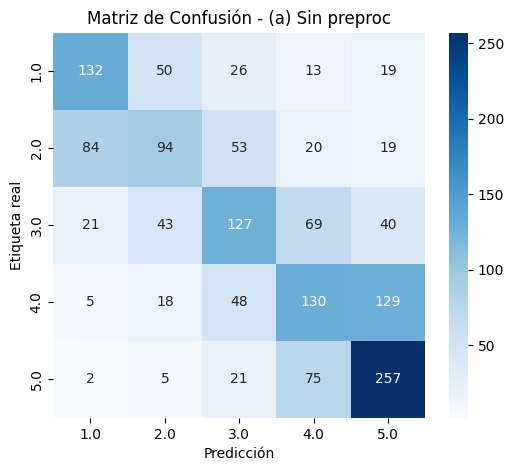

Guardada en ../reports/tables/confusion_matrix_(a)_Sin_preproc.csv


/home/diego23/Master/cimat/language-image-processing/nlp/01_Corpus_Analysis/.nlpvenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== (b) Minúsculas ===
Accuracy: 0.4980 | F1-macro: 0.4863 | F1-weighted: 0.4909

Classification report:
              precision    recall  f1-score   support

         1.0     0.5462    0.5417    0.5439       240
         2.0     0.4381    0.3407    0.3833       270
         3.0     0.4444    0.4400    0.4422       300
         4.0     0.4426    0.4091    0.4252       330
         5.0     0.5733    0.7167    0.6370       360

    accuracy                         0.4980      1500
   macro avg     0.4889    0.4896    0.4863      1500
weighted avg     0.4901    0.4980    0.4909      1500


Matriz de confusión:


,1.0,2.0,3.0,4.0,5.0
1.0,130,51,30,14,15
2.0,80,92,60,20,18
3.0,21,45,132,63,39
4.0,5,14,56,135,120
5.0,2,8,19,73,258


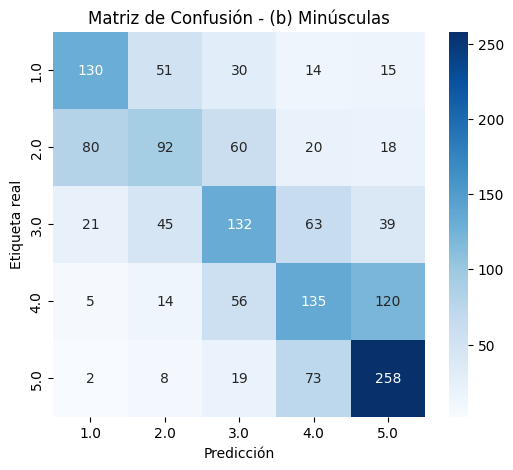

Guardada en ../reports/tables/confusion_matrix_(b)_Minúsculas.csv


/home/diego23/Master/cimat/language-image-processing/nlp/01_Corpus_Analysis/.nlpvenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== (c) Minúsculas + Stem ===
Accuracy: 0.5020 | F1-macro: 0.4910 | F1-weighted: 0.4951

Classification report:
              precision    recall  f1-score   support

         1.0     0.5331    0.5708    0.5513       240
         2.0     0.4336    0.3630    0.3952       270
         3.0     0.4684    0.4200    0.4429       300
         4.0     0.4488    0.4121    0.4297       330
         5.0     0.5753    0.7111    0.6360       360

    accuracy                         0.5020      1500
   macro avg     0.4918    0.4954    0.4910      1500
weighted avg     0.4938    0.5020    0.4951      1500


Matriz de confusión:


,1.0,2.0,3.0,4.0,5.0
1.0,137,50,25,14,14
2.0,89,98,53,13,17
3.0,23,52,126,63,36
4.0,7,18,47,136,122
5.0,1,8,18,77,256


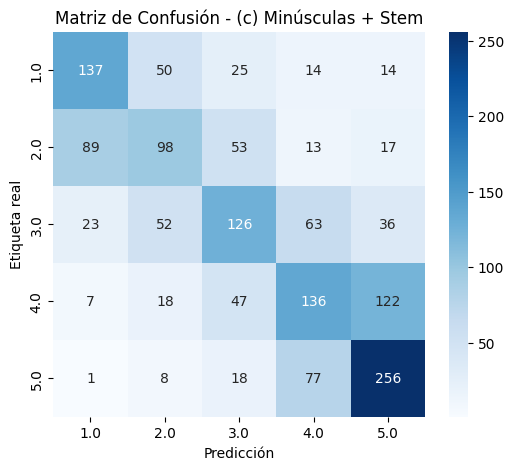

Guardada en ../reports/tables/confusion_matrix_(c)_Minúsculas_+_Stem.csv


/home/diego23/Master/cimat/language-image-processing/nlp/01_Corpus_Analysis/.nlpvenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== (d) Minúsculas + Stem + min_df=10 ===
Accuracy: 0.5000 | F1-macro: 0.4891 | F1-weighted: 0.4938

Classification report:
              precision    recall  f1-score   support

         1.0     0.5294    0.5625    0.5455       240
         2.0     0.4192    0.3556    0.3848       270
         3.0     0.4574    0.4300    0.4433       300
         4.0     0.4503    0.4121    0.4304       330
         5.0     0.5880    0.7056    0.6414       360

    accuracy                         0.5000      1500
   macro avg     0.4889    0.4931    0.4891      1500
weighted avg     0.4918    0.5000    0.4938      1500


Matriz de confusión:


,1.0,2.0,3.0,4.0,5.0
1.0,135,53,25,15,12
2.0,88,96,54,16,16
3.0,24,53,129,60,34
4.0,7,17,54,136,116
5.0,1,10,20,75,254


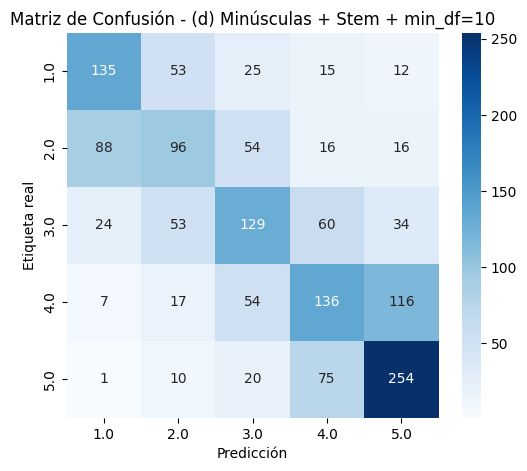

Guardada en ../reports/tables/confusion_matrix_(d)_Minúsculas_+_Stem_+_min_df=10.csv


,name,accuracy,f1_macro,f1_weighted
0,(a) Sin preproc,0.493333,0.482162,0.485625
1,(b) Minúsculas,0.498000,0.486342,0.490904
2,(c) Minúsculas + Stem,0.502000,0.491015,0.495095
3,(d) Minúsculas + Stem + min_df=10,0.500000,0.489063,0.493814


In [39]:
results = []

# (a) Sin preprocesamiento (ni lowercasing)
vec_a = TfidfVectorizer(
    lowercase=False,
    token_pattern=r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]{2,}"  # mismo patrón, pero sin forzar lower
)
res_a = run_experiment("(a) Sin preproc", vec_a)
results.append(res_a)

# (b) Con minúsculas
vec_b = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]{2,}"
)
res_b = run_experiment("(b) Minúsculas", vec_b)
results.append(res_b)

# (c) Minúsculas + stemming/lematización
if USE_LEMMA:
    vec_c = TfidfVectorizer(
        lowercase=False,            # el tokenizer ya hace lower
        tokenizer=tokenizer_lemma,  # usa lemmas
        preprocessor=None,
        token_pattern=None
    )
    suffix = "Lemma"
else:
    vec_c = TfidfVectorizer(
        lowercase=False,            # el tokenizer ya hace lower
        tokenizer=tokenizer_stem,   # usa stems
        preprocessor=None,
        token_pattern=None
    )
    suffix = "Stem"

res_c = run_experiment(f"(c) Minúsculas + {suffix}", vec_c)
results.append(res_c)

# (d) Minúsculas + stemming/lemmas + min_df=10
if USE_LEMMA:
    vec_d = TfidfVectorizer(
        lowercase=False,
        tokenizer=tokenizer_lemma,
        preprocessor=None,
        token_pattern=None,
        min_df=10
    )
else:
    vec_d = TfidfVectorizer(
        lowercase=False,
        tokenizer=tokenizer_stem,
        preprocessor=None,
        token_pattern=None,
        min_df=10
    )

res_d = run_experiment(f"(d) Minúsculas + {suffix} + min_df=10", vec_d)
results.append(res_d)

# Tabla resumen
summary = pd.DataFrame([{k: v for k, v in r.items() if k in ("name","accuracy","f1_macro","f1_weighted")} for r in results])
summary


Compara métricas (accuracy, F1 macro, matriz de confusión) y discute si el preprocesamiento es importante.

## 10. LSA con 50 tópicos

Aplica Latent Semantic Analysis (SVD truncado) con 50 tópicos.

In [ ]:
# ===============================================
# LSA con 50 tópicos (Truncated SVD)
# ===============================================

# Preparamos corpus (tokens_clean → string)
docs_clean = df["tokens_clean"].apply(lambda toks: " ".join(toks)).tolist()

# Matriz TF-IDF
vectorizer_tfidf = TfidfVectorizer(min_df=5)  # min_df=5 para filtrar ruido
X_tfidf = vectorizer_tfidf.fit_transform(docs_clean)
print("Matriz TF-IDF:", X_tfidf.shape)

# SVD truncado (LSA)
n_topics = 50
svd = TruncatedSVD(n_components=n_topics, random_state=42)
X_lsa = svd.fit_transform(X_tfidf)

print("Matriz reducida (docs x tópicos):", X_lsa.shape)
explained = svd.explained_variance_ratio_.sum()
print(f"Varianza explicada total con {n_topics} tópicos: {explained:.3f}")


Matriz TF-IDF: (5000, 4361)
Matriz reducida (docs x tópicos): (5000, 50)
Varianza explicada total con 50 tópicos: 0.123


Muestra los términos más relevantes por tópico.

In [41]:
terms = np.array(vectorizer_tfidf.get_feature_names_out())
n_top = 10  # cuántos términos mostrar por tópico

topic_terms = []
for i, comp in enumerate(svd.components_):
    top_idx = np.argsort(comp)[::-1][:n_top]
    top_terms = terms[top_idx]
    topic_terms.append({
        "topic": i,
        "terms": ", ".join(top_terms)
    })

topic_terms_df = pd.DataFrame(topic_terms)
display(topic_terms_df.head(10))

# Guardamos para el reporte
import os
os.makedirs("../reports/tables", exist_ok=True)
topic_terms_df.to_csv("../reports/tables/lsa_topics_terms.csv", index=False)
print("Guardado en ../reports/tables/lsa_topics_terms.csv")

,topic,terms
0,0,"comida, lugar, hotel, servicio, buena, si, bie..."
1,1,"comida, servicio, lugar, buena, excelente, bue..."
2,2,"hotel, habitación, habitaciones, personal, ser..."
3,3,"lugar, hotel, pena, vale, excelente, bonito, v..."
4,4,"playa, excelente, buena, ambiente, agradable, ..."
5,5,"servicio, playa, excelente, mala, meseros, ali..."
6,6,"lugar, mejor, excelente, personal, comer, boni..."
7,7,"excelente, pena, vale, restaurante, personal, ..."
8,8,"atención, excelente, buena, cenote, agua, expe..."
9,9,"buen, servicio, precio, excelente, calidad, al..."


Guardado en ../reports/tables/lsa_topics_terms.csv


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, f_classif

# --- Parámetros ---
CLASS_COL = "Polarity"
TOP_SHOW  = 10             # cuántos tópicos reportar
TOP_TERMS = 10             # cuántos términos por tópico
TOP_DOCS  = 5              # cuántos docs representativos por tópico

# Chequeos mínimos
assert 'X_lsa' in globals(), "Falta X_lsa (docs x tópicos). Ejecuta antes la celda de LSA."
assert 'svd' in globals(), "Falta el objeto svd (TruncatedSVD)."
assert 'vectorizer_tfidf' in globals(), "Falta vectorizer_tfidf (para términos)."
assert CLASS_COL in df.columns, f"No existe la columna de clase {CLASS_COL} en df."

#Etiquetas
y_raw = df[CLASS_COL].astype(str).values
le = LabelEncoder()
y = le.fit_transform(y_raw)
classes = le.classes_

# Matriz docs x tópicos
Z = X_lsa  # alias

#  Métrica 1: Mutual Information (kNN)
mi_scores = mutual_info_classif(Z, y, discrete_features=False, random_state=42)

# Ranking de tópicos por cada métrica
df_mi = pd.DataFrame({"topic": np.arange(Z.shape[1]), "MI": mi_scores})

df_mi_sorted = df_mi.sort_values("MI", ascending=False).reset_index(drop=True)

print(f"=== Top {TOP_SHOW} tópicos por Mutual Information (clase={CLASS_COL}) ===")
display(df_mi_sorted.head(TOP_SHOW))


# Términos más relevantes por tópico (para interpretación)
terms = np.array(vectorizer_tfidf.get_feature_names_out())
components = svd.components_   # shape: (n_topics, n_terms)

def top_terms_for_topic(t, k=TOP_TERMS):
    comp = components[t]
    idx = np.argsort(comp)[::-1][:k]
    return terms[idx], comp[idx]

# Docs más representativos por tópico (mayor activación absoluta)
def top_docs_for_topic(t, k=TOP_DOCS):
    col = Z[:, t]
    idx = np.argsort(np.abs(col))[::-1][:k]
    scores = col[idx]
    return idx, scores

# Construimos tablas enriquecidas para los tópicos top (por ambas métricas)
def build_topic_summary(topics_ranked, metric_name, top_k=TOP_SHOW):
    rows = []
    for t in topics_ranked[:top_k]:
        t = int(t)
        t_terms, t_weights = top_terms_for_topic(t, k=TOP_TERMS)
        d_idx, d_scores = top_docs_for_topic(t, k=TOP_DOCS)
        rows.append({
            "topic": t,
            "metric": metric_name,
            "top_terms": ", ".join(t_terms),
            "doc_ids": ", ".join(map(str, d_idx)),
            "doc_scores": ", ".join(f"{s:.3f}" for s in d_scores),
        })
    return pd.DataFrame(rows)

mi_topics  = df_mi_sorted["topic"].tolist()

summary_mi = build_topic_summary(mi_topics,  metric_name="MI", top_k=TOP_SHOW)



=== Top 10 tópicos por Mutual Information (clase=Polarity) ===


,topic,MI
0,4,0.139781
1,7,0.072530
2,2,0.054845
3,9,0.048391
4,8,0.038659
5,49,0.024363
6,23,0.021449
7,19,0.020608
8,45,0.018646
9,3,0.018297


Identifica qué tópicos son más informativos según una métrica estadı́stica y analiza su
coherencia.